# TODO:
* checking hyperparameters from paper
* checking used parameters

In [1]:
import gym
import numpy as np
from matplotlib import pyplot as plt

# **Auswahl des Spiels**

[Hier](https://gym.openai.com/envs/#atari) ist eine vollständige Liste der verfügbaren Spiele zu finden. Um ein Environment zu erstellen muss der vollständige Name des Spiels als String übergeben werden.

Beispiel:

```python
game = "MsPacman-v0"
```

In [2]:
# Hier kann das Spiel übergeben werden
game = "Breakout-v0"

# **Preprocessing**
[Stable Baselines](https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py)


### Fire Wrapper

In [3]:
class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env) 
        self.env.reset()

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        observation, _, _, _ = self.env.step(env.unwrapped.get_action_meanings().index('FIRE'))

        return observation

### Resize & Grayscale Wrapper

In [4]:
from gym import spaces
import cv2

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """
        Warp frames to 84x84 as done in the Nature paper and later work.
        :param env: (Gym Environment) the environment
        """
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255, shape=(self.height, self.width, 1),
                                            dtype=env.observation_space.dtype)
        
    def observation(self, frame):
        """
        returns the current observation from a frame
        :param frame: ([int] or [float]) environment frame
        :return: ([int] or [float]) the observation
        """
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

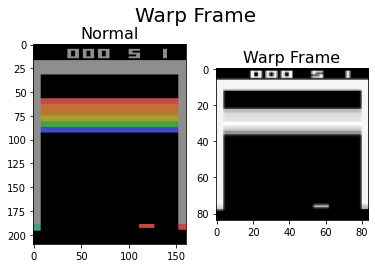

In [5]:
''' 
[OPTIONAL]

Diese Zelle ist optional ausführbar und dient zur Visualisierung des Wrappers.
Die Zelle hat keinen Einfluss auf den Agenten

'''

def WarpFrameEnv(env_name):
  env = gym.make(env_name)
  env = WarpFrame(env)
  return env

normal_env = gym.make(game)
wrapped_env = WarpFrameEnv(game)

normal_env.reset()
wrapped_env.reset()
action = normal_env.action_space.sample()

normal_state, _, _, _ = normal_env.step(action)
wrapped_state, _, _, _ = wrapped_env.step(action)

wrapped_state = wrapped_state[: , :, 0]

fig, axs = plt.subplots(1, 2)
fig.suptitle('Warp Frame', fontsize=20)
axs[0].imshow(normal_state)
axs[0].set_title("Normal", fontsize=16)
axs[1].imshow(wrapped_state, cmap="gray")
axs[1].set_title("Warp Frame", fontsize=16)
plt.show()

### Frame Stack Wrapper

In [6]:
from collections import deque

class FrameStack(gym.Wrapper):
    def __init__(self, env):
      super().__init__(env)
      self.frames = deque(maxlen=4)
      low = np.repeat(self.observation_space.low[np.newaxis, ...], repeats=4, axis=0)
      high = np.repeat(self.observation_space.high[np.newaxis, ...], repeats=4, axis=0)
      self.observation_space = gym.spaces.Box(low=low, high=high, dtype=self.observation_space.dtype)

    def step(self, action):
      obs, reward, done, info = self.env.step(action)
      self.frames.append(obs)
      frame_stack = np.asarray(self.frames, dtype=np.float32)
      frame_stack = np.moveaxis(frame_stack, 0, -1).reshape(1, 84, 84, -1)
      return frame_stack, reward, done, info

    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)
        for _ in range(4):
          self.frames.append(obs)
        frame_stack = np.asarray(self.frames, dtype=np.float32)
        frame_stack = np.moveaxis(frame_stack, 0, -1).reshape(1, 84, 84, -1)
        return frame_stack

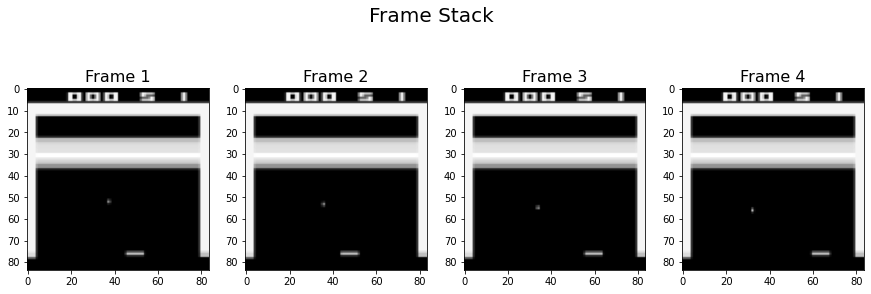

In [7]:
''' 
[OPTIONAL]

Diese Zelle ist optional ausführbar und dient zur Visualisierung des Wrappers.
Die Zelle hat keinen Einfluss auf den Agenten

'''

def FrameStackEnv(env_name):
  env = gym.make(env_name)
  env = WarpFrame(env)
  if 'FIRE' in env.unwrapped.get_action_meanings():
    env = FireResetEnv(env)
  env = FrameStack(env)
  return env

env = FrameStackEnv(game)
env.reset()

for _ in range(1, 5):
  # Führe eine zufällige Aktion aus
  state, _, _, _ = env.step(env.action_space.sample())

# Stack umformen, damit das Plotten der vier Bilder gelingt
state = state.reshape(84, 84,4)

# Frame Stack plotten
fig, axs = plt.subplots(1,4, figsize=(15, 5))
fig.suptitle('Frame Stack', fontsize=20)
for i in range(state.shape[2]):
  axs[i].imshow(state[:, :, i], cmap="gray")
  axs[i].set_title("Frame "+str(i+1), fontsize=16)
plt.show()

### Erstellen des Environments

In [8]:
def make_env(env_name):
  env = gym.make(env_name)
  env = WarpFrame(env)
  if 'FIRE' in env.unwrapped.get_action_meanings():
    env = FireResetEnv(env)
  env = FrameStack(env)
  return env

env = make_env(game)

# **Actor Network und Critic Network**

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Network Parameter
INPUT_SHAPE = (84, 84, 4) # (Höhe, Breite, Frames)
ACTOR_OUTPUT = env.action_space.n # Anzahl der möglichen Aktionen
CRITIC_OUTPUT = 1 # Bewertung der gewählten Aktion
LEARNING_RATE = 0.00025

# neuronales Netz
net_input = Input(shape=INPUT_SHAPE)
x = Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4), padding="same")(net_input)
x = Activation("relu")(x)
x = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same")(x)
x = Activation("relu")(x)
x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
x = Activation("relu")(x)
x = Flatten()(x)
x = Dense(256)(x)
x = Activation("relu")(x)


'''Aufspalten des Netzes in Actor und Critic'''

# Actor - wählt eine Aktion
actor_x = Dense(ACTOR_OUTPUT)(x)
actor_output = Activation("softmax")(actor_x)

ACTOR = Model(inputs=net_input, outputs=actor_output)
ACTOR.compile(loss="categorical_crossentropy", optimizer=Adam(lr=LEARNING_RATE))

# Critic - bewertet gewählte Aktion
critic_x = Dense(CRITIC_OUTPUT)(x)
critic_output = Activation("linear")(critic_x)

CRITIC = Model(inputs=net_input, outputs=critic_output)
CRITIC.compile(loss="mse", optimizer=Adam(lr=LEARNING_RATE))